## 용어
- 카이제곱 통계량(chi-square statistic): 기댓값으로부터 어떤 관찰값까지의 거리를 나타내는 측정치
- 기댓값(expectation): 어떤 가정(보통 귀무가설)으로부터 데이터가 발생할 때, 그에 대해 기대하는 정도
- d.f.(degree of freedom): 자유도

## 카이제곱검정
- 횟수 관련 데이터에 주로 사용되며 예상되는 분포에 얼마나 잘 맞는지를 검정

<절차><br>
1. 34개의 1(클릭한 경우)과 2966개의 0(클릭하지 않은 경우)이 들어 있는 상자를 만든다.
2. 상자의 내용물을 섞은 다음 1000개의 표본을 세 번씩 가져와서 각각의 클릭수를 계산한다.
3. 이렇게 얻은 횟수와 기대한 횟수의 차이를 제곱해서 합산한다.
4. 2~3 단계를 1000번 반복한다.
<br>
- p값: 재표본추출을 통해 얻은 편차의 제곱합이 얼마나 자주 관측값을 초과하는가?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
click_rate = pd.read_csv('../../data/click_rates.csv')

In [3]:
click_rate

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986
2,Headline B,Click,8
3,Headline B,No-click,992
4,Headline C,Click,12
5,Headline C,No-click,988


In [4]:
# 서로 다른 3가지 헤드라인에 대한 웹 테스트 결과
clicks = click_rate.pivot_table(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [5]:
# 3가지 헤드라인이 모두 같은 클릭률을 갖는다고 가정했을 때의 기댓값(귀무가설)
row_average = clicks.mean(axis=1)
expectation = pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})
expectation

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [6]:
# 피어슨 잔차(R=(관측값 - 기대값)/기대값**(1/2))
residual = (clicks-expectation)/np.sqrt(expectation)
residual.round(3)

Headline,Headline A,Headline B,Headline C
Click,,,
Click,0.792,-0.990,0.198
No-click,-0.085,0.106,-0.021


In [7]:
# 카이제곱 통계량
x_square_statistic = np.square(residual).values.sum()
x_square_statistic.round(3)

1.666

Observed chi2: 1.6659
Resampled p-value: 0.4960


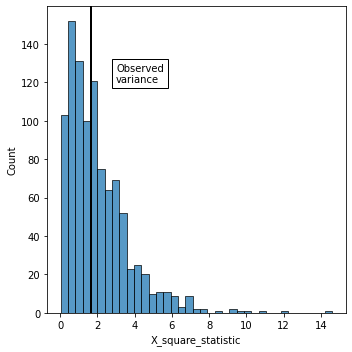

In [8]:
box = [1]*34
box.extend([0]*2966)
random.shuffle(box)

def perm_fun(box, expectation):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_nonclicks = [1000 - n for n in sample_clicks]
    clicks_random = pd.DataFrame(columns=['Headline A', 'Headline B', 'Headline C'])
    clicks_random.loc['Click'] = sample_clicks
    clicks_random.loc['No-click'] = sample_nonclicks
    residual = (clicks_random - expectation)/np.sqrt(expectation)
    x_square_statistic = np.square(residual).values.sum()
    return x_square_statistic

x_square_statistic_random = [perm_fun(box, expectation) for _ in range(1000)]
resampled_p_value = np.mean([x_square_random > x_square_statistic for x_square_random in x_square_statistic_random])
print(f'Observed chi2: {x_square_statistic:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=x_square_statistic_random, ax=ax)
ax.axvline(x=x_square_statistic, color='black', linewidth=2)
ax.text(3, 120, s='Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('X_square_statistic')

plt.tight_layout()
plt.show()

## 카이제곱분포

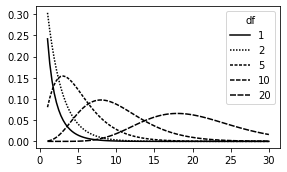

In [9]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

In [10]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


## 피셔의 정확검정
- 발생할 수 있는 모든 조합(순열)을 실제로 열거하고, 빈도를 집계하고, 관찰된 결과가 얼마나 극단적으로 발생할 수 있는지를 정확하게 결정하는 절차

In [11]:
# stats.fisher_exact(clicks.values) # scipy에서는 (2, 2)형태에서만 피셔의 정확검정을 제공